In [122]:
import pandas
import matplotlib.pyplot as plt

In [86]:
dat_path = 'C:\\Users\\ogeid\\Documents\\My Documents\\CU Boulder\\ds2_repo\\data\\Biocuration_EDI_Survey_2021-09-13_v2.csv'

data = pandas.read_csv(dat_path, header=0)
data = data.drop(columns=['Timestamp'])
# Change column names to shorter things.
data.rename(columns={"What is your highest degree?":"Degree", "What is your job title?":"Job Title",
                     "What is your highest degree(s) in?":"Deg Field","Please indicate your gender":"Gender",
                     "What is your salary range?":"Salary","How satisfied are you with your job?":"Job Satisfaction",
                     "How satisfied are you with your career progression?":"Career Satisfaction",
                     "How satisfied are you with your work environment?":"Work Env Satisfaction",
                     "How satisfied are you with the way that you are evaluated in terms of your success in your job?":"Eval Satisfaction",
                     "Have you been promoted while in your job?":"Promoted?",
                     "Do you play a leadership role in your position?":"Leadership",
                     "How far away is your home institution?":"Distance",
                     "Before the pandemic did you work from home or in an office?":"WFH?",
                     "How flexible are your working hours?":"Flex Hours?",
                     "Which of the following best describes the organization where you currently perform most of your biocuration work?" +
                         " Choose all that apply.":"Org Type",
                     "What do you consider the most important scholarly product that you generate?":"Key Product",
                     "How long have you been in the curation field?":"Experience"}, inplace=True)

# Drop table row #29 due to bad survey answer.
data = data[data["Flex Hours?"] != data["Flex Hours?"][29]]

In [87]:
# Edit some of the response fields.
# Start with function definitions.
def process_wfh_answers(ans:str) -> str:
    pos_answers = ['Exclusively at an office at my institution',
                   'Exclusively from home',
                   'I am able to work from home or at an office at my institution']
    answers = ans.split(';')
    if pos_answers[0] in answers:
        return 'Office'
    elif pos_answers[1] in answers:
        return 'Home'
    elif pos_answers[2] in answers:
        return 'Hybrid'
    else:
        return ans
    
def process_time_answers(ans:str) -> str:
    pos_answers = ['I need to be at work during regular business hours, but can flex my schedule when needed.',
                   'I choose my working hours.','I must be at work during specific hours.']
    answers = ans.split(sep=';')
    if pos_answers[2] in answers:
        return 'No'
    elif pos_answers[0] in answers:
        return 'Some'
    elif pos_answers[1] in answers:
        return 'Yes'
    else:
        return ans
    
def process_degree(ans):
    if "M.D." in ans:
        return "MD"
    elif "DSc." in ans:
        return "DSc"
    else:
        return ans
    
def process_lead(ans):
    if isinstance(ans, list):
        return ans
    if pandas.isna(ans):
        return ['None']
    answers = ans.split(';')
    out_arr = []
    cats = ['papers','grants','manage','training','projects']
    for a in answers:
        a = a.lower()
        for c in cats:
            if c in a:
                out_arr.append(c.capitalize())
    return out_arr

# Process WFH and Hours columns.
data['WFH?'] = [process_wfh_answers(ans) for ans in data['WFH?']]
data['Flex Hours?'] = [process_time_answers(ans) for ans in data['Flex Hours?']]

# Drop rows where WFH? field could not be parsed.
data = data[[el in ['Office','Home','Hybrid'] for el in data['WFH?']]]

# Process the Org Type field to accept multiple answers.
data = data[pandas.notna(data["Org Type"])]
data["Org Type"] = [org.split(';') for org in data["Org Type"]]

# Process leadership roles
data["Leadership"] = [process_lead(ans) for ans in data["Leadership"]]
# Drop rows where leadership role could not be parsed.
data = data[[len(arr) != 0 for arr in data["Leadership"]]]

#Process degree column.
data["Degree"] = [process_degree(ans) for ans in data["Degree"]]

# Process the promoted column.
data = data[[ans in ['Yes','No'] for ans in data["Promoted?"]]]

# Make relevant columns categorical.
data["Degree"] = data["Degree"].astype("category")
data["Gender"] = data["Gender"].astype("category")
data["Flex Hours?"] = data["Flex Hours?"].astype("category")
data["WFH?"] = data["WFH?"].astype("category")
data["Promoted?"] = data["Promoted?"].astype("category")

# Visualizing Data

## Dataset Summary
The dataset in question is comprised of survey responses to the 2021 survey of the [International Society for Biocuration](https://www.biocuration.org/about/). The survey was open to both members and nonmembers.

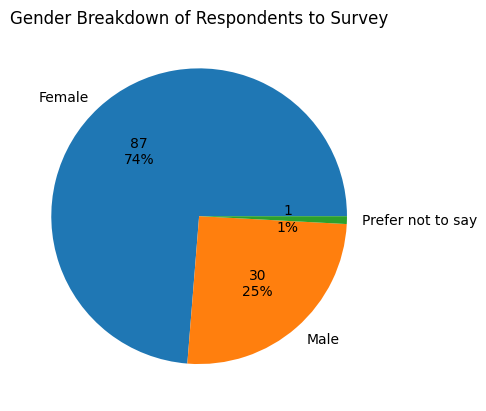

In [125]:
def label_function(val):
    return f'{val / 100 * len(data):.0f}\n{val:.0f}%'

fig, ax = plt.subplots()
data.groupby("Gender").size().plot(kind='pie', autopct=label_function, ax=ax)
plt.title("Gender Breakdown of Respondents to Survey")
plt.show()

We see that the respondents are overwhelmingly female.

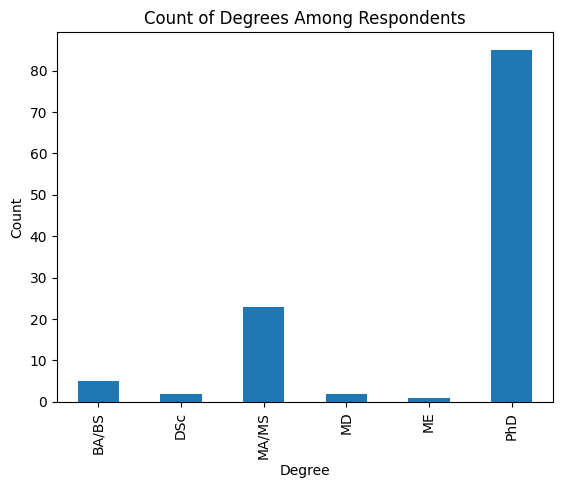

In [143]:
fig, ax = plt.subplots()
p = data.groupby("Degree").size().plot(kind='bar', ax=ax)
ax.set_ylabel("Count")
ax.set_title(label="Count of Degrees Among Respondents")
plt.show()

We see that the respondents overwhelmingly have advanced degrees.